#Importing Libraries

In [35]:
# Import necessary libraries for computation and modeling
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame, concat
import keras

# Set a random seed to ensure reproducibility of results
keras.utils.set_random_seed(1234)





#Uploading .csv Dataset to Execude the following code


In [36]:
from google.colab import files

def upload_files():
    # Prompt the user to upload files through the dialog interface
    uploaded_files = files.upload()

    # Confirm the successful upload and display details for each file
    for file_name in uploaded_files.keys():
        print(f'File "{file_name}" uploaded successfully, size: {len(uploaded_files[file_name])} bytes')

    # Save the uploaded files to the local file system for further operations
    for file_name in uploaded_files.keys():
        with open(file_name, 'wb') as file:
            file.write(uploaded_files[file_name])

upload_files()


Saving Beijing_outlier_removed.csv to Beijing_outlier_removed (3).csv
File "Beijing_outlier_removed (3).csv" uploaded successfully, size: 6783690 bytes


#Reading the .csv files as pandas dataset


In [37]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv("Beijing_outlier_removed.csv")

# Display the DataFrame
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,sin_dir,cos_dir,wind_direction,wind_direction_degrees,AQHI
0,6.833333,9.833333,5.333333,13.111111,308.333333,75.750000,-1.216667,1023.191667,-19.916667,0.0,3.875000,-0.249528,0.717289,-0.334782,-19.181605,3.129724
1,6.000000,9.250000,5.833333,12.400000,283.333333,75.333333,-1.891667,1024.208333,-21.833333,0.0,3.366667,-0.346071,0.775598,-0.419688,-24.046378,3.059368
2,4.833333,6.916667,6.750000,14.000000,308.333333,66.333333,-2.283333,1024.866667,-21.625000,0.0,2.716667,-0.340467,0.847333,-0.382066,-21.890749,2.827127
3,5.500000,6.583333,7.666667,13.545455,333.333333,70.583333,-2.766667,1025.275000,-20.941667,0.0,2.575000,-0.130189,0.800005,-0.161321,-9.242987,2.954489
4,5.333333,7.333333,10.916667,18.454545,383.333333,68.333333,-3.266667,1026.058333,-20.108333,0.0,1.950000,-0.054071,0.761423,-0.070894,-4.061901,3.121171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26742,16.083333,38.416667,3.583333,28.818182,408.333333,71.900000,12.000000,1011.950000,-15.133333,0.0,2.141667,-0.481986,0.699747,-0.603170,-34.559112,4.035945
26743,19.000000,38.166667,5.083333,41.666667,533.333333,56.545455,10.933333,1012.141667,-14.191667,0.0,1.275000,-0.688671,0.366979,-1.081192,-61.947727,4.282490
26744,15.666667,33.083333,5.000000,40.833333,558.333333,54.000000,10.041667,1012.625000,-13.558333,0.0,1.350000,-0.235702,0.686887,-0.330556,-18.939440,4.071514
26745,13.666667,29.666667,5.500000,40.166667,591.666667,53.250000,9.225000,1012.841667,-13.166667,0.0,1.466667,-0.218377,0.779487,-0.273152,-15.650469,3.960568


# **This cell includes all the necessary functions to train an RNN model using the optimal hyperparameters**


In [38]:
# Function to handle missing values by interpolation
def handle_missing_values(dataset):
    interpolated_data = dataset.interpolate()
    interpolated_data = interpolated_data.apply(pd.to_numeric, errors='coerce')
    return interpolated_data

#########################################

# Function to scale the dataset using MinMax scaling
def scale_dataset(dataset):
    values = dataset.values.astype('float32')
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(values)
    return scaled_values

##################################

# Function to transform a time series into a supervised learning problem
def convert_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Convert time series data into a supervised learning format.
    Arguments:
        data: The time series data (list or NumPy array).
        n_in: Number of lag observations as inputs.
        n_out: Number of future observations as outputs.
        dropnan: Whether to remove rows with NaN values.
    Returns:
        A DataFrame representing the time series data in supervised learning format.
    """
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []

    # Create input sequences (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    # Create output sequences (t, t+1, ..., t+n)
    for i in range(n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    # Combine columns and drop NaN rows if needed
    supervised_data = concat(cols, axis=1)
    supervised_data.columns = names
    if dropnan:
        supervised_data.dropna(inplace=True)
    return supervised_data

##########################################

# Function to train an RNN model
def train_rnn(dataset, df, n, rnn_units, dense_units, air_property, name, plot_name, epochs=100, batch_size=32, learning_rate=0.001):
    # Mapping air quality properties to column indices
    property_dict = {"AQHI": -1, "PM2.5": -16, "PM10": -15, "SO2": -14, "NO2": -13, "CO": -12, "O3": -11}

    # Split data into training, validation, and test sets
    values = dataset.values
    num_samples = len(values)
    n_train = int(num_samples * 0.7)
    n_valid = int(num_samples * 0.9)
    train, valid, test = values[:n_train], values[n_train:n_valid], values[n_valid:]

    # Define input and output for the RNN model
    u = 16 * n
    train_X, train_y = train[:, :-u], train[:, property_dict[air_property]]
    valid_X, valid_y = valid[:, :-u], valid[:, property_dict[air_property]]
    test_X, test_y = test[:, :-u], test[:, property_dict[air_property]]

    # Reshape inputs to 3D for RNN
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Build the RNN model
    timesteps = train_X.shape[1]
    input_dim = train_X.shape[2]
    output_dim = 1

    inputs = keras.Input(shape=(timesteps, input_dim))
    tf.random.set_seed(1234)

    rnn_out = SimpleRNN(rnn_units, activation='relu', return_sequences=False)(inputs)
    dense = Dense(dense_units, activation='relu')(rnn_out)
    output = Dense(output_dim, activation='linear')(dense)

    rnn_model = keras.Model(inputs=inputs, outputs=output)
    rnn_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

    # Early stopping callback to prevent overfitting
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    # Train the model
    history = rnn_model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, callbacks=[callback], validation_data=(valid_X, valid_y))

    # Plot training and validation loss
    plot_loss(history, plot_name)

    # Evaluate the model performance
    errors = evaluate_model(rnn_model, df, test_X, test_y, air_property, name)

    return rnn_model, errors

############################################################
# Function to plot the training and validation loss
def plot_loss(history, title, plot_name):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))

    plt.figure(figsize=(4, 2), dpi=150)  # Reduced figure size and DPI
    plt.plot(epochs, loss, "black", label="Training loss")
    plt.plot(epochs, val_loss, color="gray", label="Validation loss")
    plt.title(title, fontsize=8)  # Reduced font size
    plt.xlabel("Epochs", fontsize=8)  # Reduced font size
    plt.ylabel("Loss", fontsize=8)  # Reduced font size
    plt.legend(fontsize=8)  # Reduced font size
    plt.tight_layout()
    plt.show()
    plt.close()

########################################

# Function to compare the actual vs predicted values visually
def compare_predictions(data1, data2, air_property, plot_name='time_series.png'):
    fig, ax = plt.subplots(figsize=(4, 2), dpi=150)  # Reduced figure size and DPI

    data1[air_property].plot(ax=ax, color='black', label="Actual", lw=4)
    data2[air_property].plot(ax=ax, color='gray', label="Prediction", lw=4)

    ax.set_xlabel("Hour", fontsize=8)  # Reduced font size
    ax.set_ylabel(air_property, fontsize=8)  # Reduced font size
    ax.set_title(plot_name, fontsize=8)  # Reduced font size
    ax.tick_params(axis='both', labelsize=8)  # Reduced font size
    ax.legend(fontsize=8)  # Reduced font size

    plt.tight_layout()
    plt.show()
    plt.close()


######################################################

# Function to evaluate the model performance
def evaluate_model(model, dataset, test_X, test_y, air_property, name):
    property_dict = {"AQHI": -1, "PM2.5": -16, "PM10": -15, "SO2": -14, "NO2": -13, "CO": -12, "O3": -11}
    predictions = model.predict(test_X)

    # Inverse scaling to get actual values
    inv_predictions = inverse_scale(dataset, predictions, air_property)
    inv_test_y = inverse_scale(dataset, test_y, air_property)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(inv_test_y, inv_predictions))
    mae = mean_absolute_error(inv_test_y, inv_predictions)
    r2 = r2_score(inv_test_y, inv_predictions)

    print(f'Test RMSE: {rmse:.3f}')
    print(f'Test MAE: {mae:.3f}')
    print(f'Test R2: {r2:.3f}')

    # Plot comparison of actual vs predicted values
    compare_predictions(DataFrame(inv_test_y[-100:], index=dataset.index[-100:], columns=[dataset.columns[property_dict[air_property]]]),
                        DataFrame(inv_predictions[-100:], index=dataset.index[-100:], columns=[dataset.columns[property_dict[air_property]]]),
                        air_property, name)

    return rmse, mae, r2

################################################

# Function to inverse scale the data
def inverse_scale(df, y, air_property):
    property_dict = {"AQHI": -1, "PM2.5": -16, "PM10": -15, "SO2": -14, "NO2": -13, "CO": -12, "O3": -11}
    max_val = df.max()[property_dict[air_property]]
    min_val = df.min()[property_dict[air_property]]

    inv_y = y.copy()
    for i in range(len(inv_y)):
        inv_y[i] = inv_y[i] * (max_val - min_val) + min_val
    return inv_y

##############################################


#RNN

Epoch 1/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0082 - mae: 0.0581 - val_loss: 0.0020 - val_mae: 0.0316
Epoch 2/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - mae: 0.0302 - val_loss: 0.0015 - val_mae: 0.0260
Epoch 3/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - mae: 0.0288 - val_loss: 0.0016 - val_mae: 0.0269
Epoch 4/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - mae: 0.0275 - val_loss: 0.0013 - val_mae: 0.0230
Epoch 5/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0017 - mae: 0.0264 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 6/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0017 - mae: 0.0258 - val_loss: 0.0012 - val_mae: 0.0218
Epoch 7/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0012 - val_mae: 0.0220
Epoch 8/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mae: 0.0252 - val_loss: 0.0012 - val_mae: 0.0215
Epoch 9/100
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/

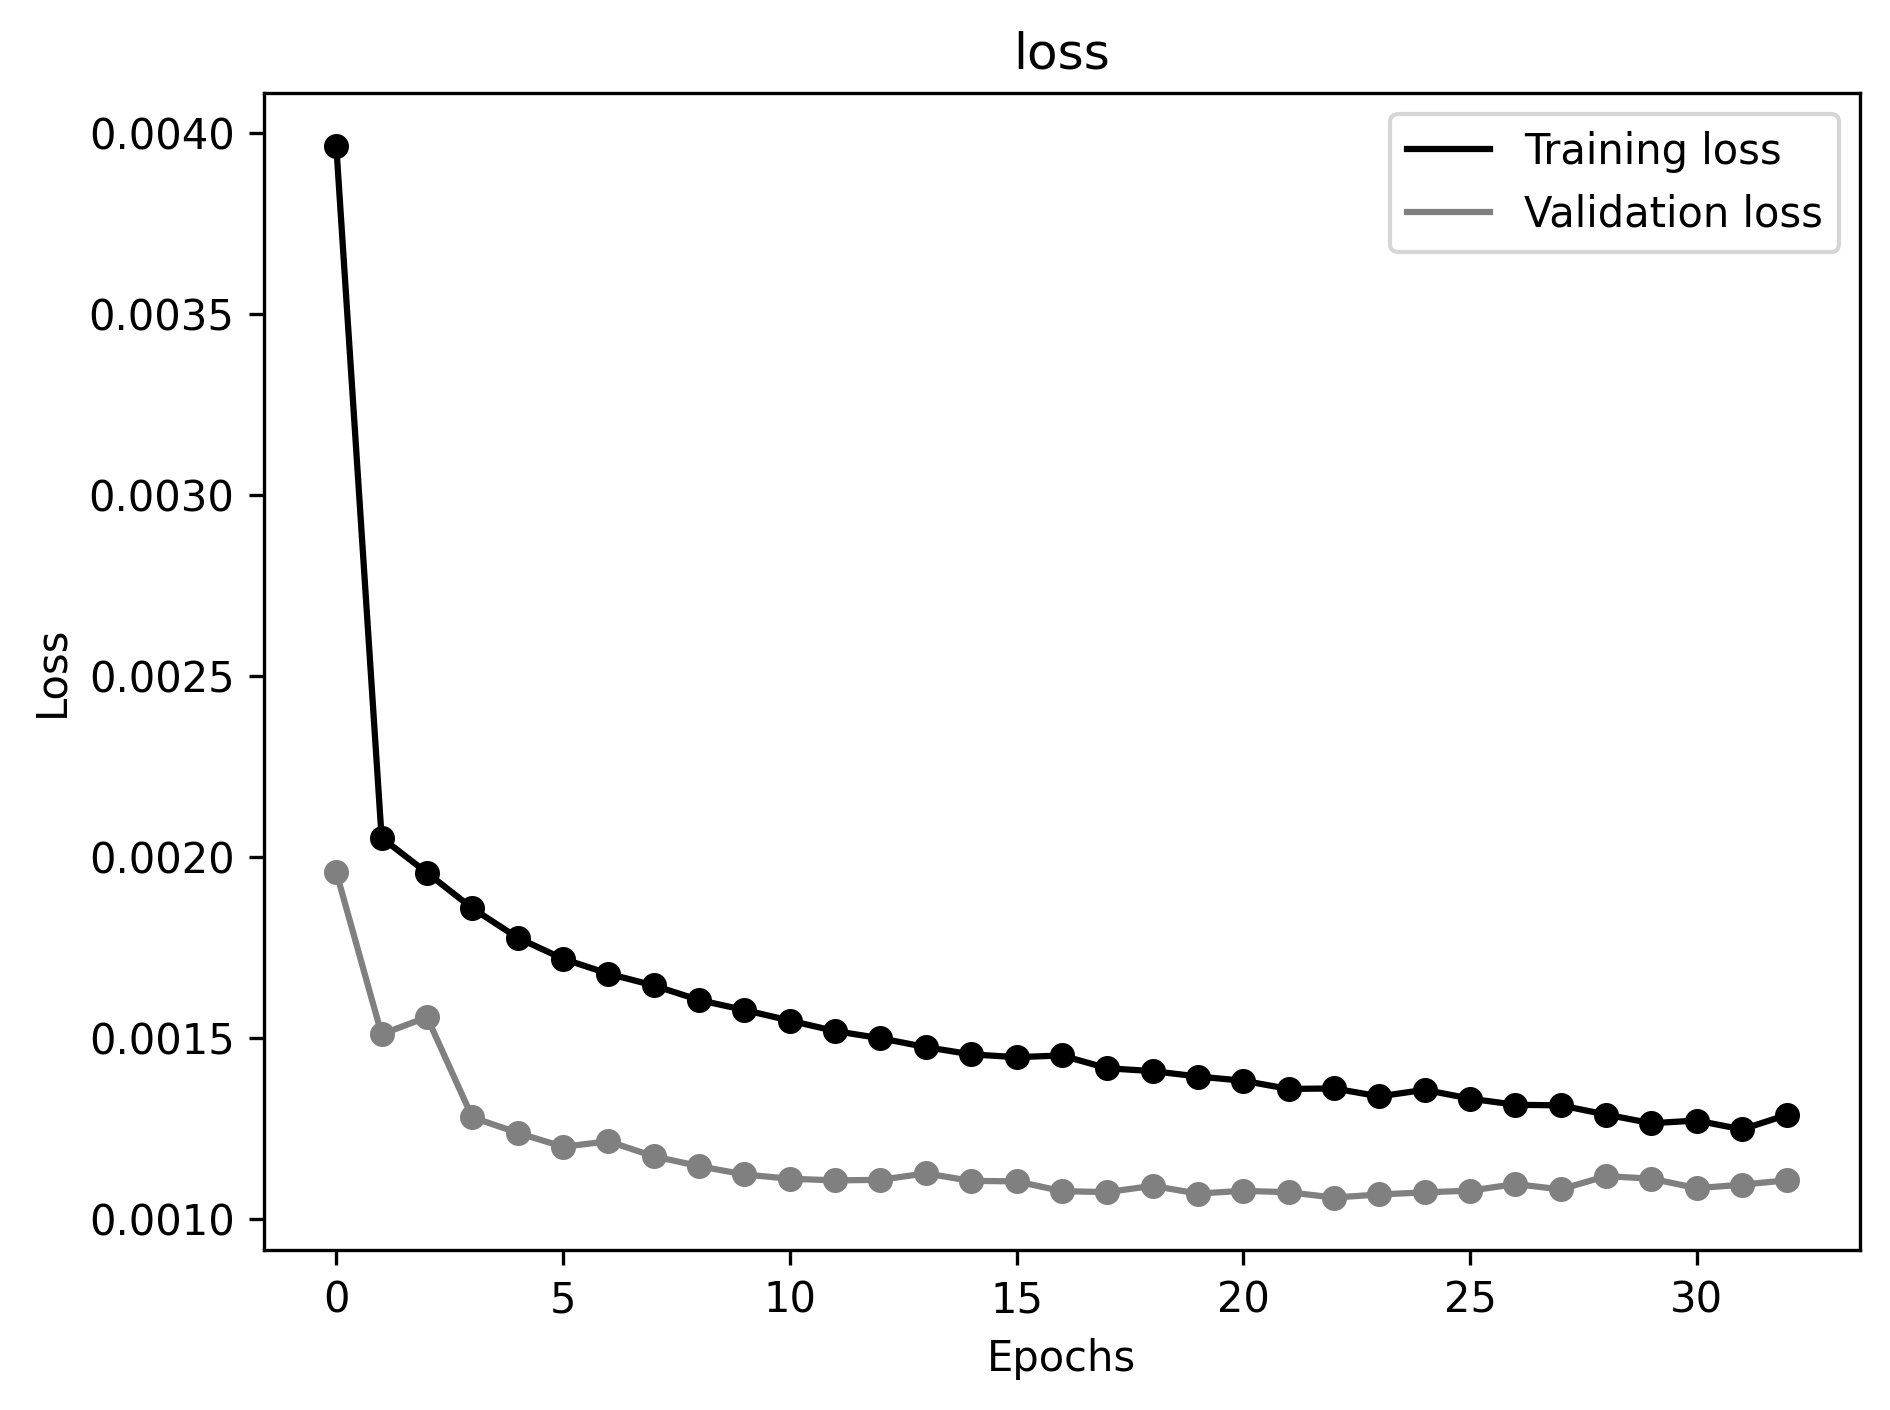

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test RMSE: 0.550
Test MAE: 0.302
Test R2: 0.944


<ipython-input-28-606b9860a296>:227: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max = df.max()[dict[air_property]]
<ipython-input-28-606b9860a296>:228: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min = df.min()[dict[air_property]]


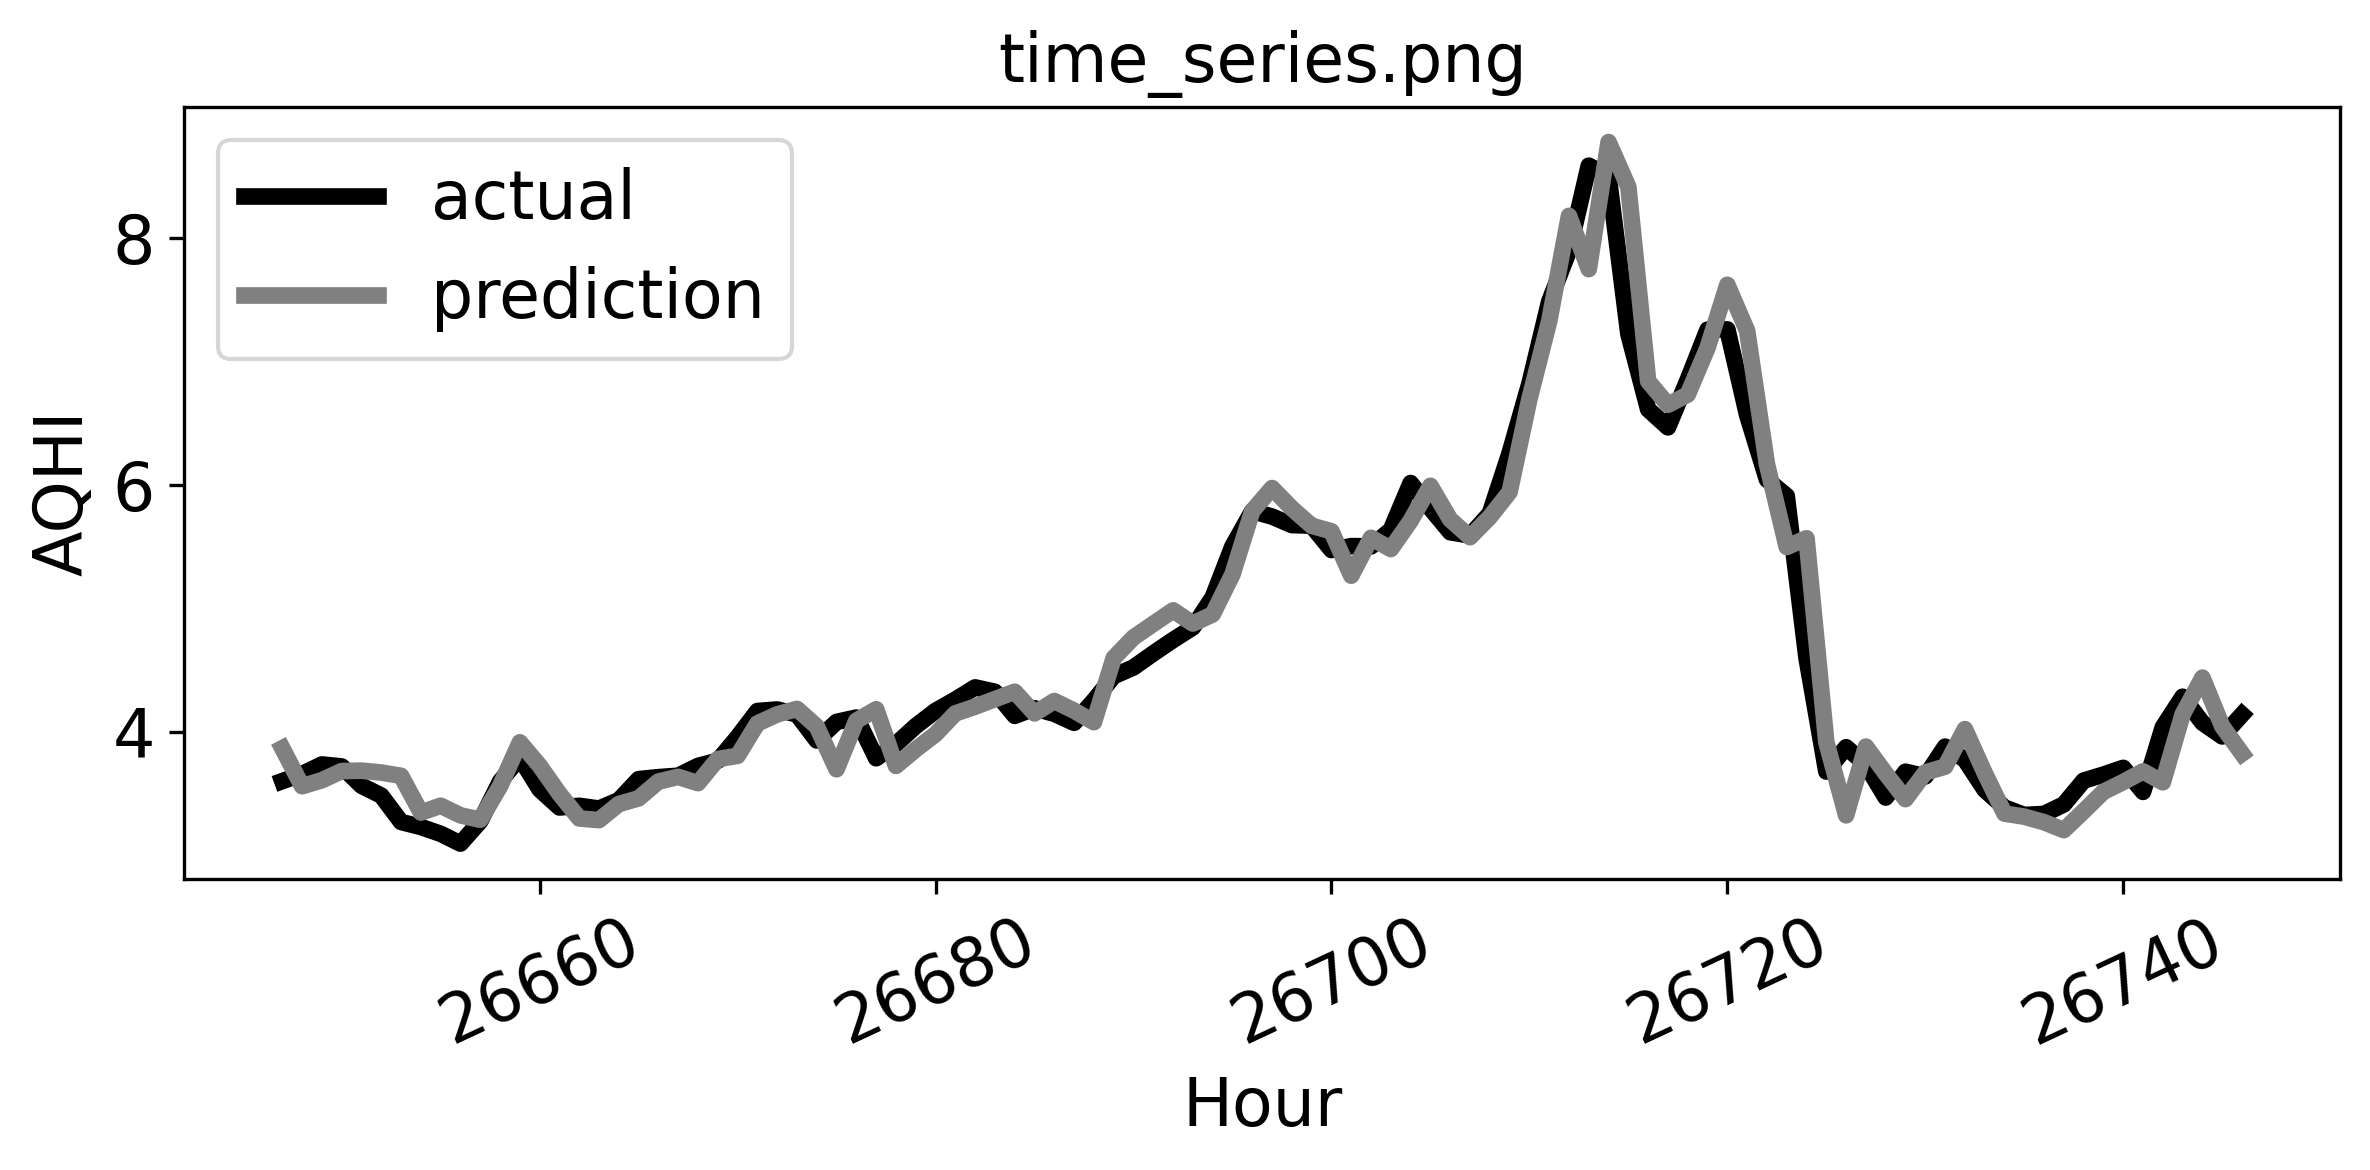

In [39]:
RNN = dataset_pipeline_rnn(df,3,1,64,128,'AQHI',name = 'time_series.png',name1="loss",epochs = 100,batch_size = 32,learning_rate = 0.001)


In [40]:
RNN

(<Functional name=functional_3, built=True>,
 (0.5502437, 0.30238932, 0.9440205693244934))

In [41]:
RNN[0].weights

[<KerasVariable shape=(48, 64), dtype=float32, path=simple_rnn_3/simple_rnn_cell/kernel>,
 <KerasVariable shape=(64, 64), dtype=float32, path=simple_rnn_3/simple_rnn_cell/recurrent_kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=simple_rnn_3/simple_rnn_cell/bias>,
 <KerasVariable shape=(64, 128), dtype=float32, path=dense_6/kernel>,
 <KerasVariable shape=(128,), dtype=float32, path=dense_6/bias>,
 <KerasVariable shape=(128, 1), dtype=float32, path=dense_7/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=dense_7/bias>]

In [42]:
model,errors = RNN

In [43]:
model

<Functional name=functional_3, built=True>

In [44]:
errors

(0.5502437, 0.30238932, 0.9440205693244934)